In [1]:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, Value, ClassLabel, Features
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, DistilBertTokenizer
from transformers import AutoModelForSequenceClassification,  DistilBertModel
from transformers import AutoConfig, DistilBertConfig
from transformers import pipeline
import wandb

In [3]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'

# Load Data

In [4]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/data/datasets/train.csv')
train_df=train_df.drop(columns=['ID'])

In [5]:
train_df.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_set, test_temp = train_test_split(train_df, test_size=0.4, random_state=42)
valid_set, test_df = train_test_split(test_temp, test_size=0.5, random_state=42)

In [8]:
train_text = train_set['Tweet'].values
train_label = train_set.drop(columns=['Tweet']).to_numpy().astype('float32')

valid_text = valid_set['Tweet'].values
valid_label = valid_set.drop(columns=['Tweet']).to_numpy().astype('float32')

test_text = test_df['Tweet'].values
test_label = test_df.drop(columns=['Tweet']).to_numpy().astype('float32')



In [9]:
test_df.head()

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
6742,@ZubairSabirPTI pls dont insult the word 'Molna',1,0,1,0,0,0,0,0,0,0,0
1313,"If you find me lost, will you stay as a passer...",0,0,0,0,1,0,0,0,1,0,1
1582,@officialShaky 'Operation Echoes' is gathering...,0,1,0,1,1,0,1,0,0,0,0
3433,“Set a goal to achieve something that is so bi...,0,0,0,0,1,0,1,0,0,0,0
6467,i was just talking about it last week .. how d...,0,1,1,0,0,0,0,1,1,0,0


In [10]:
(train_text.shape, train_label.shape, valid_text.shape, valid_label.shape, test_text.shape, test_label.shape)

((4634,), (4634, 11), (1545,), (1545, 11), (1545,), (1545, 11))

# Create Huggingface DataSet

In [11]:
trainset = Dataset.from_dict({
    'texts': train_text,
    'labels': train_label
})

validset = Dataset.from_dict({
    'texts': valid_text,
    'labels': valid_label
})

testset = Dataset.from_dict({
    'texts': test_text,
    'labels': test_label
})

emotion_dataset = DatasetDict({
    'train': trainset,
    'valid': validset
})

print(trainset)
print(validset)
print(emotion_dataset)

Dataset({
    features: ['texts', 'labels'],
    num_rows: 4634
})
Dataset({
    features: ['texts', 'labels'],
    num_rows: 1545
})
DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 4634
    })
    valid: Dataset({
        features: ['texts', 'labels'],
        num_rows: 1545
    })
})


# Load pre-trained Tokenizer

In [12]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Create function for Tokenizer

In [13]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True, padding='max_length', return_tensors="pt",max_length = 128)

In [14]:
tokenized_traindataset= trainset.map(tokenize_fn, batched=True)
tokenized_validdataset= validset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/4634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [15]:
tokenized_traindataset = tokenized_traindataset.remove_columns(
    ['texts']
)
tokenized_traindataset.set_format(type='torch')
tokenized_traindataset[1]

{'labels': tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'input_ids': tensor([  101,  1045,  2288,  1037,  2460, 19976,  2043, 10047, 17358,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,   

# Model Training

## Download pre-trained model

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, problem_type = "multi_label_classification", num_labels = 11)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Download and Modify Model Config File

In [17]:
config = AutoConfig.from_pretrained(checkpoint)

In [18]:
tokenized_traindataset.features

{'labels': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [19]:
class_names = train_set.columns.tolist()[1:]


id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id
model.config = config

len(class_names)

11

## Compute Metrics

In [20]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # print(logits.shape)
    preds = (logits > 0).astype(int)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy':accuracy['accuracy'],
            }

## Train Args

In [21]:
# Define the directory where model checkpoints will be saved
run_name = "distilBERT"
base_folder = Path(basepath)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    # auto_find_batch_size=True,
    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=50,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch_fused',  # Optimizer,


    # Checkpoint saving and model evaluation settings
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    output_dir=str(model_folder),

    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases
    fp16=True,
)


## Initialize Trainer

In [22]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_traindataset,
    eval_dataset=tokenized_validdataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Setup wand

In [23]:
!wandb login 'Write your personal key for WandB login'
%env WANDB_PROJECT = run_name

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
env: WANDB_PROJECT=run_name


## Training and Validation

In [24]:
trainer.train()

wandb: Currently logged in as: maniverthummala (mani_utd). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
50,0.614300,0.498376,0.000000,0.000000,0.028479
100,0.478000,0.463503,0.000000,0.000000,0.028479
150,0.424400,0.393912,0.513831,0.257187,0.175405
200,0.370800,0.365880,0.567751,0.304137,0.188350
250,0.338200,0.354192,0.587552,0.338226,0.201294
300,0.326500,0.347192,0.600298,0.351275,0.207120
350,0.316900,0.344825,0.603693,0.366190,0.204531


TrainOutput(global_step=365, training_loss=0.40609518469196476, metrics={'train_runtime': 71.0386, 'train_samples_per_second': 326.161, 'train_steps_per_second': 5.138, 'total_flos': 767440562864640.0, 'train_loss': 0.40609518469196476, 'epoch': 5.0})

Evaluate model on Validation Set

In [25]:
eval_results = trainer.evaluate(tokenized_validdataset)

In [26]:
eval_results

{'eval_loss': 0.34482499957084656,
 'eval_f1_micro': 0.6036927134849983,
 'eval_f1_macro': 0.36619003925416355,
 'eval_accuracy': 0.2045307443365696,
 'eval_runtime': 1.1044,
 'eval_samples_per_second': 1398.907,
 'eval_steps_per_second': 22.636,
 'epoch': 5.0}

In [27]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"],
"eval_f1_micro": eval_results["eval_f1_micro"], "eval_f1_macro": eval_results["eval_f1_macro"]})

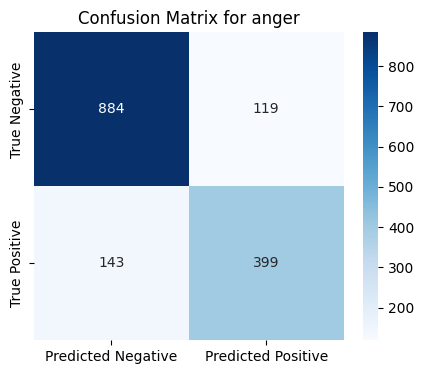

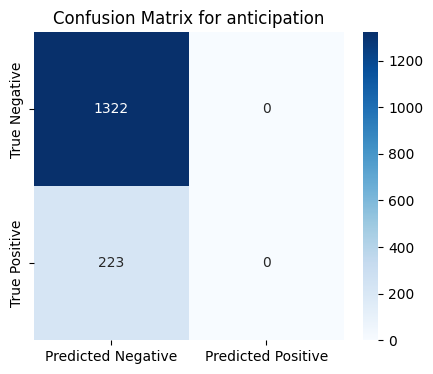

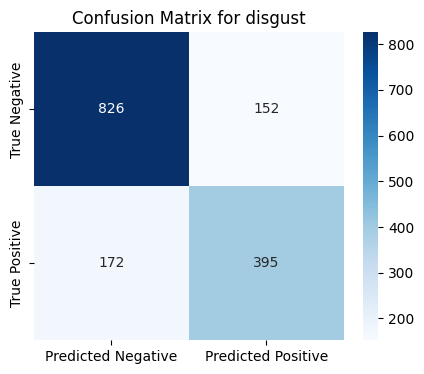

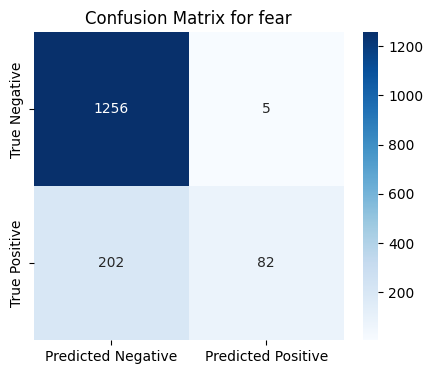

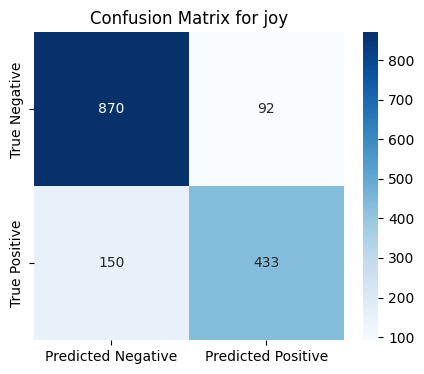

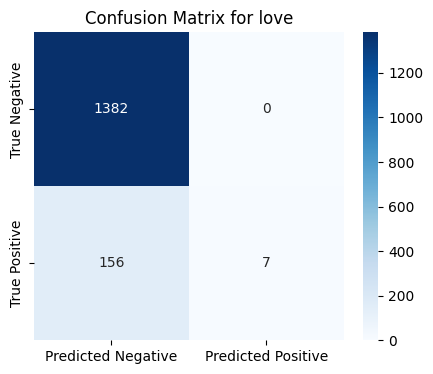

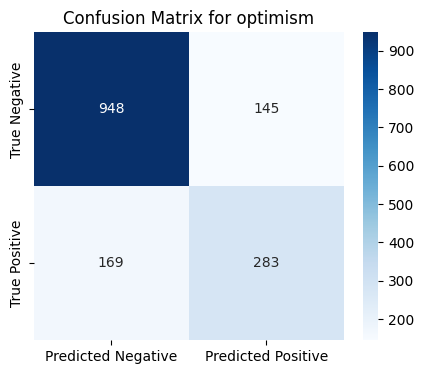

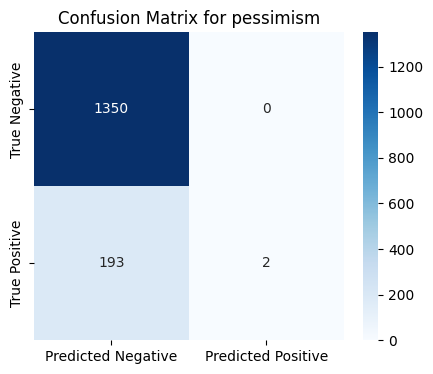

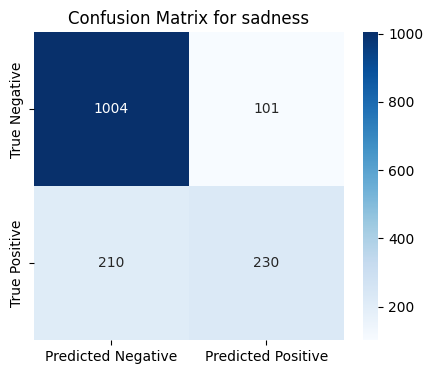

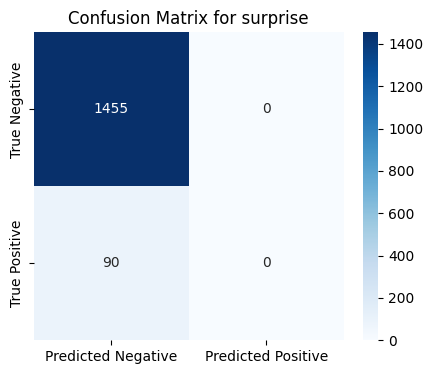

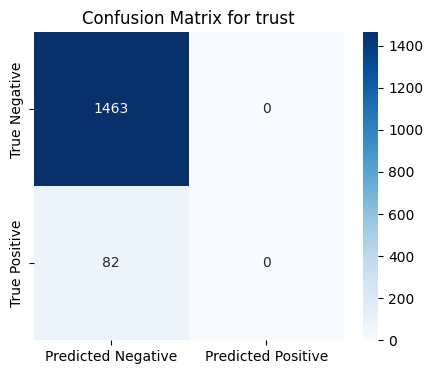

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


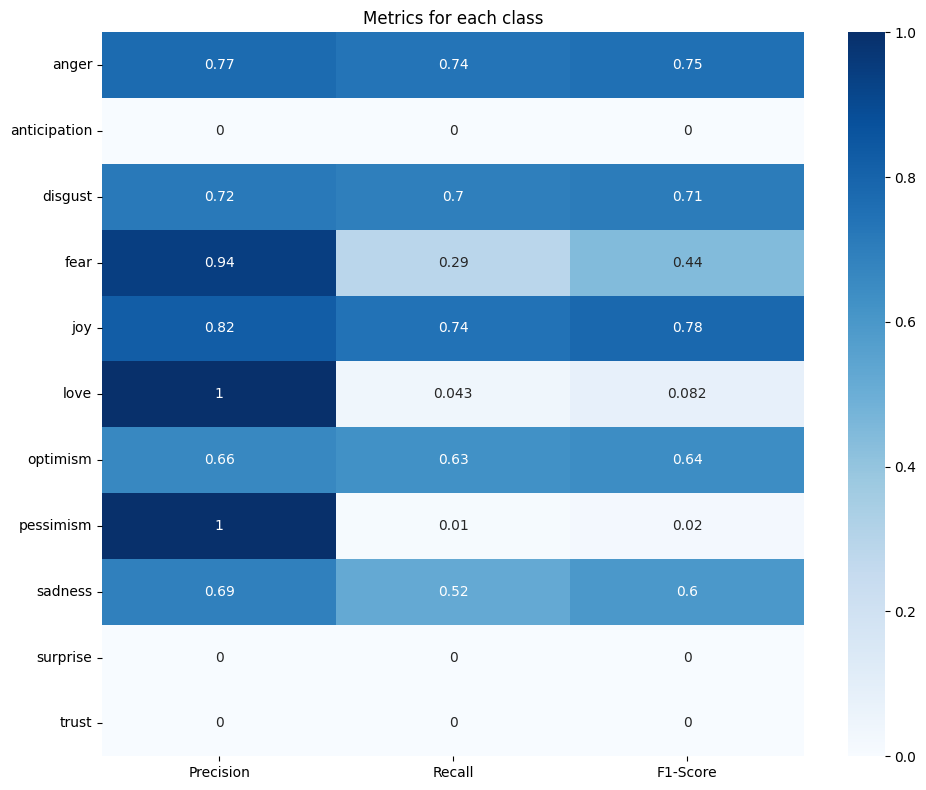

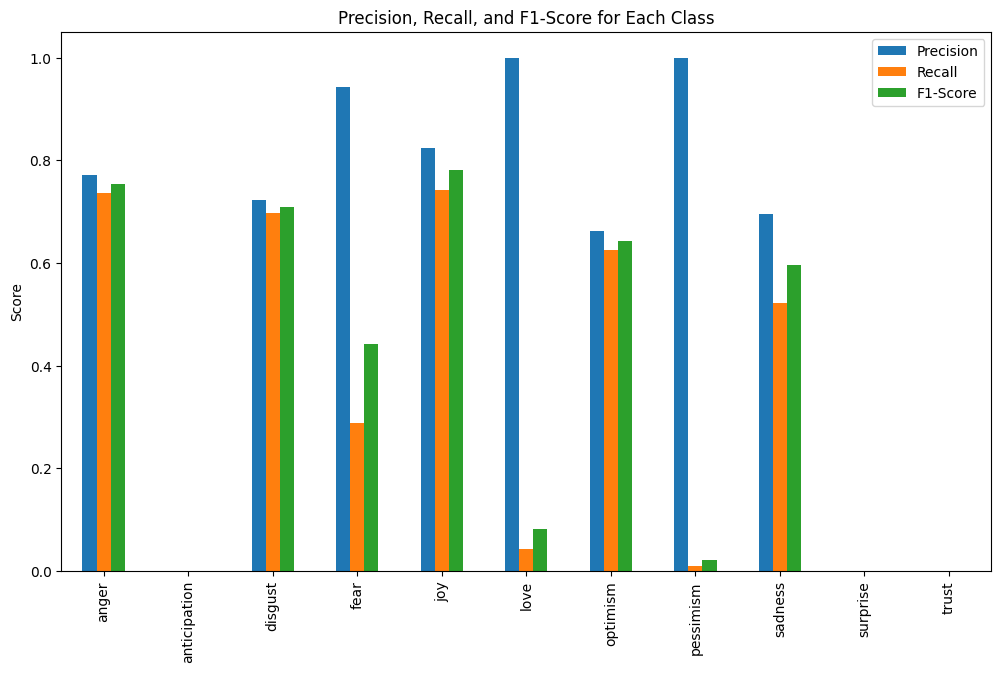

In [29]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
valid_output = trainer.predict(tokenized_validdataset)

predictions_valid = (valid_output.predictions > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

# from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Sample data
y_true = labels_valid
y_pred = predictions_valid
class_names = class_names

mcm = multilabel_confusion_matrix(y_true, y_pred,)

# 1. Individual Heatmaps
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
# sns.heatmap(metrics_df, annot=True, cmap='Blues')
# plt.title('Metrics for each class')
# plt.show()

ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()




Check best points

In [30]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 350.


# Performance on Test set

In [31]:

checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/checkpoint-350'

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [33]:
test_set_tokenized = testset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Training Arguments

In [34]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

Instantiate Trainer

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Evaluate using Trainer

In [36]:
test_results= trainer.evaluate()

In [37]:
test_results

{'eval_loss': 0.34258604049682617,
 'eval_f1_micro': 0.6237639811963043,
 'eval_f1_macro': 0.37996760064528934,
 'eval_accuracy': 0.23106796116504855,
 'eval_runtime': 1.037,
 'eval_samples_per_second': 1489.938,
 'eval_steps_per_second': 12.537}

In [38]:
test_output = trainer.predict(test_set_tokenized)

In [39]:
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = np.array(test_output.label_ids)


In [40]:
wandb.finish()

eval/accuracy,▁▁▇▇████
eval/f1_macro,▁▁▆▇▇███
eval/f1_micro,▁▁▇█████
eval/loss,█▆▃▂▁▁▁▁
eval/runtime,▅▅██▄▃▁▆
eval/samples_per_second,▄▄▁▁▅▆█▃
eval/steps_per_second,▄▄▁▁▅▆█▃
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


# Model Inference

In [41]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=0)

Test the pipeline on a single example

In [42]:
sample = testset['texts'][0]
preds = custom_pipeline(sample)
preds


[{'label': 'anger', 'score': 0.7996585965156555}]

Test the pipeline on a large dataset

In [43]:
predictions = custom_pipeline(testset['texts'], truncation=True)

In [44]:
predictions[0:10]

[{'label': 'anger', 'score': 0.7996585965156555},
 {'label': 'sadness', 'score': 0.8103319406509399},
 {'label': 'joy', 'score': 0.5826780200004578},
 {'label': 'joy', 'score': 0.7847819924354553},
 {'label': 'disgust', 'score': 0.496637225151062},
 {'label': 'fear', 'score': 0.6370487213134766},
 {'label': 'fear', 'score': 0.5132567286491394},
 {'label': 'joy', 'score': 0.6316503882408142},
 {'label': 'sadness', 'score': 0.3371107280254364},
 {'label': 'disgust', 'score': 0.2742788791656494}]

### **Model 2**
### Similar Sized Model using Distilroberta-base

In [47]:

## Choose a similar-sized model (e.g., distilroberta-base)
similar_model_checkpoint = "distilroberta-base"  # or "albert-base-v2" or any similar-sized model
similar_model = AutoModelForSequenceClassification.from_pretrained(similar_model_checkpoint, problem_type="multi_label_classification", num_labels=11)

## Adjust the configuration if necessary
similar_config = AutoConfig.from_pretrained(similar_model_checkpoint)
similar_class_names = train_set.columns.tolist()[1:]
similar_id2label = {id_: label_ for id_, label_ in enumerate(similar_class_names)}
similar_label2id = {label_: id_ for id_, label_ in enumerate(similar_class_names)}
similar_config.id2label = similar_id2label
similar_config.label2id = similar_label2id
similar_model.config = similar_config

## Initialize Trainer for the similar model
similar_trainer = Trainer(
    model=similar_model,
    args=training_args,
    train_dataset=tokenized_traindataset,
    eval_dataset=tokenized_validdataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [48]:
# Model Selection and Training
!wandb login e0c9aaab5dcf40aab08ad0e3eeedcdc9b5b032ab
%env WANDB_PROJECT = run_name
wandb.init()


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
env: WANDB_PROJECT=run_name


In [50]:

## Training and Validation for the similar model
similar_trainer.train()
similar_eval_results = similar_trainer.evaluate(tokenized_validdataset)
#wandb.log({"similar_eval_accuracy": similar_eval_results["eval_accuracy"], "similar_eval_loss": similar_eval_results["eval_loss"], "similar_eval_f1": similar_eval_results["eval_f1"]})
print(similar_eval_results)
wandb.finish()

Step,Training Loss
500,0.403600
1000,0.363000
1500,0.331700


{'eval_loss': 0.4422653317451477, 'eval_f1_micro': 0.5093227091633467, 'eval_f1_macro': 0.33390453350415783, 'eval_accuracy': 0.17540453074433657, 'eval_runtime': 1.0703, 'eval_samples_per_second': 1443.479, 'eval_steps_per_second': 12.146, 'epoch': 3.0}
